In [28]:
using Plots
using Random

In [29]:
mutable struct Particles
    n :: Int
    pos :: AbstractArray{Float64, 2}
    vel :: AbstractArray{Float64, 2}
end

In [30]:
function gravity(particles::Particles) :: AbstractArray{Float64, 2}
    vec_x = particles.pos[1, :] .- particles.pos[1, :]'
    vec_y = particles.pos[2, :] .- particles.pos[2, :]'
    vec_z = particles.pos[3, :] .- particles.pos[3, :]'

    r_sq = (vec_x.^2 + vec_y.^2 + vec_z.^2) .+ 1e-6

    force_x = -vec_x ./ r_sq
    force_y = -vec_y ./ r_sq
    force_z = -vec_z ./ r_sq

    force_x = sum(force_x, dims=2)
    force_y = sum(force_y, dims=2)
    force_z = sum(force_z, dims=2)

    force = [force_x force_y force_z]

    return transpose(force)
end

gravity (generic function with 1 method)

In [31]:
# kick drift kick / leap frog
function kdk(particles::Particles, dt::Float64)
    # compute a(t)
    force = gravity(particles)
    # v(t + dt/2) = v(t) + a(t) * dt/2
    particles.vel .+= force .* dt / 2
    # x(t + dt) = x(t) + v(t + dt/2) * dt
    particles.pos .+= particles.vel .* dt
    # a(t + dt)
    force = gravity(particles)
    # v(t + dt) = v(t + dt/2) + a(t + dt) * dt/2
    particles.vel .+= force .* dt / 2
end

# reverse time integration
function rev_kdk(particles::Particles, dt::Float64)
    # compute a(t)
    force = gravity(particles)
    # v(t - dt/2) = v(t) - a(t) * dt/2
    particles.vel .-= force .* dt / 2
    # compute x(t - dt)
    particles.pos .-= particles.vel .* dt
    # a(t - dt)
    force = gravity(particles)
    # v(t - dt) = v(t - dt/2) - a(t - dt) * dt/2
    particles.vel .-= force .* dt / 2
end

rev_kdk (generic function with 1 method)

In [42]:

function compute_reverse_error(
    n_particles::Int, n_steps::Int, n_dims::Int, dt::Float64    ) :: Float64

    particles = Particles(n_particles, rand(n_dims, n_particles).-0.5, rand(n_dims, n_particles).-0.5)

    particles_fwd = zeros(n_dims, n_particles, n_steps)
    particles_bwd = zeros(n_dims, n_particles, n_steps)

    # do the forward simulation
    for i in 1:n_steps
        kdk(particles, dt)
        particles_fwd[:, :, i] = particles.pos
    end

    # do the backward simulation
    particles_bwd[:, :, 1] = particles.pos
    for i in 1:n_steps-1
        rev_kdk(particles, dt)
        particles_bwd[:, :, i+1] = particles.pos
    end

    # compute the error
    error = sum((particles_fwd[:, :, end] .- particles_bwd[:, :, end]).^2) / (n_particles)

    return error

end

compute_reverse_error (generic function with 1 method)

In [44]:
n_measures = 8
n_shots = 5

5

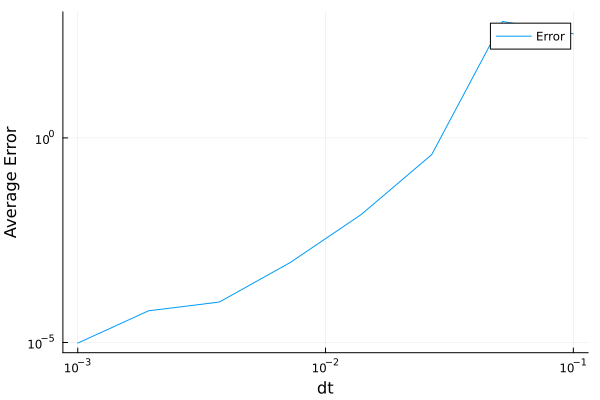

In [45]:
# lets see if the error increases with higher dt

errors = zeros(n_measures)
# log scale range of dts
dts = 10.0.^(range(-3,stop=-1,length=n_measures))

for i in 1:n_measures
    for j in 1:shots
        errors[i] += compute_reverse_error(200, 100, 3, dts[i])
    end
    errors ./= shots
end

plot(dts, errors, xaxis=:log, yaxis=:log, label="Error", xlabel="dt", ylabel="Average Error")
# store the plot
# savefig("reverse_error.png")

In [52]:
# lets see if it also increase with more particle
errors = zeros(n_measures)
# range of num_particles
num_particles = range(10, stop=400, length=n_measures)

for i in 1:n_measures
    for j in 1:shots
        errors[i] += compute_reverse_error(Int(floor(num_particles[i])), 100, 3, 1e-2)
    end
    errors ./= shots
end